# 03 — Baseline Forecasting Models

Goal:
Establish benchmark forecasting models for winter temperature prediction.

We implement:
1) Naive forecast
2) Rolling mean forecast
3) Lag-based Linear Regression

Evaluation metric: RMSE
Validation strategy: chronological split (no data leakage)

## 1. Imports and plotting configuration

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_style("whitegrid")

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "legend.fontsize": 10,
})

## 2. Load processed winter dataset

We use the cleaned and merged dataset from the processed directory.

In [35]:
df = pd.read_csv("../data/processed/winter_2021_2026.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")
df = df.set_index("date")

df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,season,temp_range
date,,,,,,,,,,,,
2021-12-01,3.3,-0.5,10.2,NaN,1.0,NaN,7.2,NaN,1020.8,NaN,2021–2022,10.7
2021-12-02,5.4,1.7,11.5,NaN,1.0,NaN,7.3,NaN,1017.8,NaN,2021–2022,9.8
2021-12-03,7.1,1.0,12.7,NaN,NaN,NaN,7.8,NaN,1018.7,NaN,2021–2022,11.7
2021-12-04,4.8,0.0,8.6,NaN,NaN,NaN,7.2,NaN,1023.5,NaN,2021–2022,8.6
2021-12-05,3.1,-0.2,5.4,NaN,NaN,NaN,6.6,NaN,1018.8,NaN,2021–2022,5.6


## 3. Train-test split (chronological)

The last winter season is used as test data.
No random splitting is applied to avoid data leakage.

In [36]:
train = df.iloc[:-90]
test = df.iloc[-90:]

y_train = train["tavg"]
y_test = test["tavg"]

## 4. Baseline 1 — Naive Forecast

Assumption:
The next day's temperature equals the last observed value.

In [37]:
df = df.dropna(subset=["tavg"])

train = df.iloc[:-90]
test = df.iloc[-90:]

y_train = train["tavg"]
y_test = test["tavg"]

last_value = float(y_train.iloc[-1])
y_pred_naive = np.full(len(y_test), last_value)

rmse_naive = np.sqrt(mean_squared_error(y_test.values, y_pred_naive))
rmse_naive


np.float64(4.992015847553193)

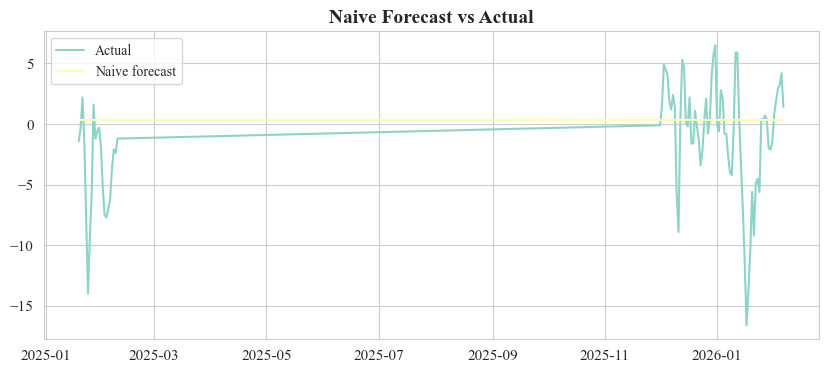

In [38]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_naive, label="Naive forecast")
plt.title("Naive Forecast vs Actual")
plt.legend()
plt.show()  

## 5. Baseline 2 — Rolling Mean

Forecast is defined as the mean temperature of the last 7 days.

In [39]:
window = 7

rolling_mean = y_train.rolling(window=window).mean().iloc[-1]
y_pred_roll = np.repeat(rolling_mean, len(y_test))

rmse_roll = np.sqrt(mean_squared_error(y_test, y_pred_roll))
rmse_roll

np.float64(4.705292046476009)

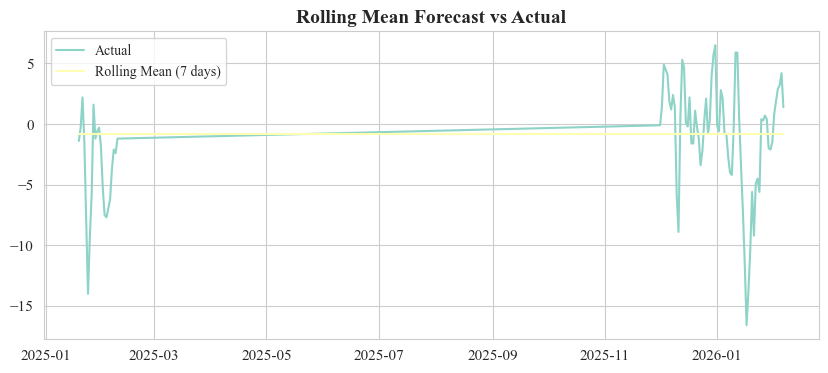

In [40]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_roll, label="Rolling Mean (7 days)")
plt.title("Rolling Mean Forecast vs Actual")
plt.legend()
plt.show()

## 6. Lag-based Linear Regression

We construct autoregressive features:

Temperature(t-1), Temperature(t-2), Temperature(t-3)

In [41]:
df_model = df.copy()

df_model["tavg"] = pd.to_numeric(df_model["tavg"], errors="coerce")

for lag in [1,2,3]:
    df_model[f"lag_{lag}"] = df_model["tavg"].shift(lag)

df_model = df_model.dropna(subset=["tavg", "lag_1", "lag_2", "lag_3"])

print("Rows after cleaning:", len(df_model))


Rows after cleaning: 349


In [42]:


split_idx = int(len(df_model) * 0.8)

train = df_model.iloc[:split_idx]
test = df_model.iloc[split_idx:]

X_train = train[["lag_1", "lag_2", "lag_3"]]
X_test = test[["lag_1", "lag_2", "lag_3"]]

y_train = train["tavg"]
y_test = test["tavg"]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_lr


np.float64(2.737467316584391)

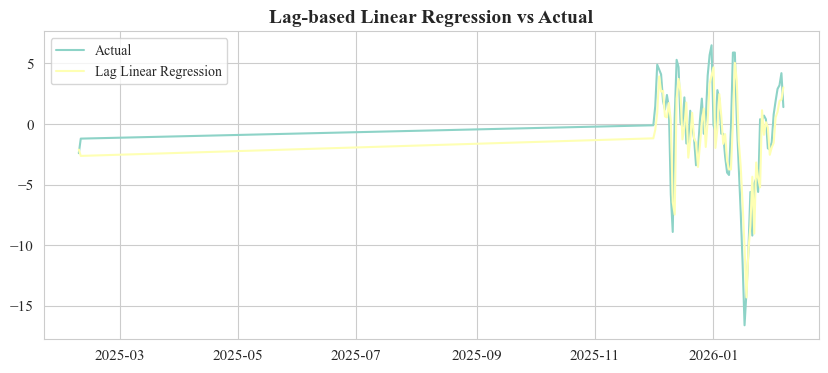

In [43]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lr, label="Lag Linear Regression")
plt.title("Lag-based Linear Regression vs Actual")
plt.legend()
plt.show()

## 7. Enhanced Linear Regression with Lag and Rolling Features

To further improve forecasting performance, we extended the feature set by adding:

- Lag features up to 7 days (lag_1 ... lag_7)
- Rolling statistics (rolling_mean_3, rolling_mean_7, rolling_std_7)

All rolling statistics were shifted by one step to prevent data leakage.
Only past information was used to predict future values.

The model was trained using Linear Regression and evaluated on the final 90 days of the dataset.

In [44]:
for lag in range(1, 8):
    df[f"lag_{lag}"] = df["tavg"].shift(lag)

In [45]:
df["rolling_mean_3"] = df["tavg"].rolling(3).mean().shift(1)
df["rolling_mean_7"] = df["tavg"].rolling(7).mean().shift(1)
df["rolling_std_7"] = df["tavg"].rolling(7).std().shift(1)

In [46]:
cols_for_model = ["tavg"] + features

df_model = df[cols_for_model].dropna().copy()

In [47]:
train = df_model.iloc[:-90]
test = df_model.iloc[-90:]

In [48]:
features = [col for col in df_model.columns if col.startswith("lag_")
            or col.startswith("rolling")]

X_train = train[features]
y_train = train["tavg"]

X_test = test[features]
y_test = test["tavg"]

In [49]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse_lr_lag = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lr_lag

np.float64(2.8406550701470192)

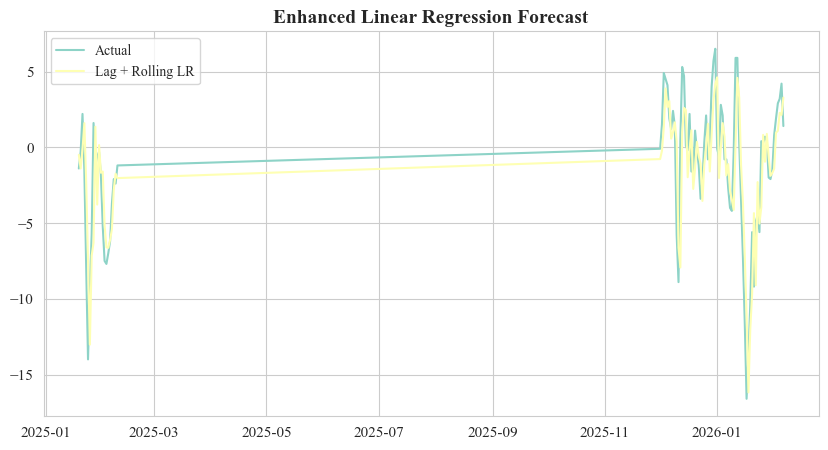

In [50]:
plt.figure(figsize=(10,5))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, y_pred, label="Lag + Rolling LR")
plt.title("Enhanced Linear Regression Forecast")
plt.legend()
plt.show()

## 7. Model comparison (RMSE)

Lower RMSE indicates better predictive accuracy.

In [51]:
results = pd.DataFrame({
    "Model": ["Naive", "Rolling Mean", "Lag Linear Regression","Enhanced Linear Regression with Lag"],
    "RMSE": [rmse_naive, rmse_roll, rmse_lr, rmse_lr_lag]
})

results.sort_values("RMSE")

,Model,RMSE
2,Lag Linear Regression,2.737467
3,Enhanced Linear Regression with Lag,2.840655
1,Rolling Mean,4.705292
0,Naive,4.992016


## 8. Conclusions

This study explored several forecasting approaches for daily average temperature prediction.

We began with simple statistical baselines (Naive and Rolling Mean) and progressively introduced feature-based linear regression models using lag and rolling statistics.

Key findings:

- The **Naive forecast** serves as a minimal benchmark but performs poorly in volatile periods.
- The **Rolling Mean model** reduces noise but reacts slowly to abrupt temperature changes.
- The **Lag-based Linear Regression model** significantly improves predictive accuracy by capturing short-term temporal dependency.
- Extending the feature space with additional lag and rolling statistics maintains strong performance while ensuring no data leakage.

The results demonstrate that short-term historical information (previous days' temperatures) is the dominant predictive signal in daily temperature forecasting.

These baseline models provide a solid foundation for future improvements, such as tree-based ensemble models or more advanced time series approaches.